In [19]:
# Load a local copy of the current ODYM branch:
import sys, os
import numpy as np
import openpyxl
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import pylab


# For Ipython Notebook only
%matplotlib inline

sys.path.insert(0, os.path.join('..', '..', 'odym', 'modules'))  # add ODYM module directory to system path, relative
sys.path.insert(0, os.path.join(os.getcwd(), '..', '..', 'odym',
                                'modules'))  # add ODYM module directory to system path, absolute
# Import ODYM stuff
import ODYM_Classes as msc
import ODYM_Functions as msf
import dynamic_stock_model as dsm

In [20]:
# Specify path to dynamic stock model and to datafile, relative
MainPath = os.path.join('..', '..', 'odym', 'modules')
DataPath = os.path.join('.')
sys.path.insert(0, MainPath)  # add ODYM module directory to system path

# Load data from file
inflow_file = 'Sawnwood_Consumption_Final_Europe.xlsx'
inflow_datasheetname = 'FinalConsumptionSawnwood_ob_est'
inflow_row_start = 2
inflow_num_rows = 61
inflow_row_end = inflow_row_start + inflow_num_rows
inflow_col_index_region = 3
inflow_col_index_year = 4
inflow_col_product_name = 5
inflow_col_index_consumption = 6

# Count automatically how many years are in Excel file
file = openpyxl.load_workbook(os.path.join(DataPath, inflow_file), data_only=True)
file_datasheet = file[inflow_datasheetname]

# Get min and max years in column that contains years (inflow_col_year)
num_rows_found = 0
available_years = []
available_rows = list(file_datasheet.iter_rows())

# Detect years automatically from the file
for row in available_rows:
    # Decrease index by one because when using iterators
    # then columns start from 0, elsewhere use the initial
    # value
    value = row[inflow_col_index_year - 1].value
    if not isinstance(value, int):
        continue

    num_rows_found = num_rows_found + 1
    available_years.append(value)

# These are the minimum and maximum years found in the years column in Excel file
# Also the count of the years
starting_year = min(available_years)
ending_year = max(available_years)
num_years = len(available_years)
years = np.arange(starting_year, ending_year + 1)

inflow_row_end = inflow_row_start + num_rows_found

### For the inflow array, we also need to assign the flow values to the right countries:
InflowFile = openpyxl.load_workbook(os.path.join(DataPath, inflow_file), data_only=True)
Datasheet = InflowFile[inflow_datasheetname]

values_sawnwood = []
# InflowArray = np.zeros((1, num_years))  # OriginRegion x Year
for m in range(inflow_row_start, inflow_row_end):
    value = Datasheet.cell(m, inflow_col_index_consumption).value
    values_sawnwood.append(value)
    # OriginCountryPosition = MyRegions.index(Datasheet.cell(m, inflow_col_index_region).value)
    # YearPosition = MyYears.index(int(Datasheet.cell(m, inflow_col_index_year).value))
    # InflowArray[OriginCountryPosition, YearPosition] = Datasheet.cell(m, inflow_col_index_consumption).value


In [21]:
# Track only 1 element: carbon
model = dict()
model['Time'] = msc.Classification(Name='Time', Dimension='Time', ID=1, Items=years)
model['Element'] = msc.Classification(Name='Elements', Dimension='Element', ID=2, Items=['C'])

# Get model time start, end, and duration:
model_time_start = int(min(model['Time'].Items))
model_time_end = int(max(model['Time'].Items))
model_duration = model_time_end - model_time_start

In [22]:
index_table = pd.DataFrame({'Aspect': ['Time', 'Element'],  # 'Time' and 'Element' must be present!
                            'Description': ['Model aspect "time"', 'Model aspect "Element"'],
                            'Dimension': ['Time', 'Element'],  # 'Time' and 'Element' are also dimensions
                            'Classification': [model[Aspect] for Aspect in ['Time', 'Element']],
                            'IndexLetter': ['t',
                                            'e']})  # Unique one letter (upper or lower case) indices to be used later for calculations.

index_table.set_index('Aspect', inplace=True)  # Default indexing of IndexTable, other indices are produced on the fly
#print(index_table)

In [23]:
mfa_system = msc.MFAsystem(Name='Wood product system',
                           Geogr_Scope='Utopia',
                           Unit='Mm3',
                           ProcessList=[],
                           FlowDict={},
                           StockDict={},
                           ParameterDict={},
                           Time_Start=model_time_start,
                           Time_End=model_time_end,
                           IndexTable=index_table,
                           Elements=index_table.loc['Element'].Classification.Items)  # Initialize MFA system

In [24]:
# Start with empty process list, only process numbers (IDs) and names are needed.
mfa_system.ProcessList = []
mfa_system.ProcessList.append(msc.Process(Name='Apparent wood consumption', ID=0))
mfa_system.ProcessList.append(msc.Process(Name='P1', ID=1))
mfa_system.ProcessList.append(msc.Process(Name='P2', ID=5))
mfa_system.ProcessList.append(msc.Process(Name='VAM1', ID=2))
mfa_system.ProcessList.append(msc.Process(Name='VAM2', ID=3))
mfa_system.ProcessList.append(msc.Process(Name='Waste', ID=4))

In [25]:
# Parameters for the system
# Share/proportions of elements in sawnwood, now only track 1 element (= carbon)
composition_sawnwood = np.array([1.0])

# Efficiency of making sawnwood products
efficiency_sawnwood = np.array([1.00])

# Keys in the dictionary are the names of the processes
shares = {
    "P1": {
        "VAM1": [0.4],  # Share of P1 -> VAM1
        "VAM2": [0.4],
        "Waste": [0.2],
    },
    "P2": {
        "VAM1": [0.4],
        "VAM2": [0.4],
        "Waste": [0.2],
    },
}

# Lifetimes for stocks in years
stock_lifetimes = {
    "VAM1": 20,
    "VAM2": 30,
    "Waste": 50,
}

# Keys in the dictionary are the names of the processes
flow_shares = {
    "P1": {
        "VAM1": [0.4],  # Share of P1 -> VAM1
        "VAM2": [0.4],
        "Waste": [0.2],
    },
    "P2": {
        "VAM1": [0.4],
        "VAM2": [0.4],
        "Waste": [0.2],
    },
}


params_dict = dict()
params_dict['F_0_1'] = msc.Parameter(
    Name='Inflow of product 1', ID=1, P_Res=1, MetaData=None, Indices='te',
    Values=np.einsum('t,e->te', values_sawnwood, composition_sawnwood),
    Unit='Mm3/yr')

params_dict['efficiency_sawnwood'] = msc.Parameter(
    Name='Efficiency of product 1', ID=2, P_Res=1, MetaData=None, Indices='e', Values=efficiency_sawnwood, Unit='1')

eff_vam1 = np.array([1])
params_dict['efficiency_vam1'] = msc.Parameter(
    Name='Efficiency of VAM1', ID=3, P_Res=2, MetaData=None, Indices='e', Values=eff_vam1, Unit='1')

eff_vam2 = np.array([1])
params_dict['efficiency_vam2'] = msc.Parameter(
    Name='Efficiency of VAM2', ID=4, P_Res=3, MetaData=None, Indices='e', Values=eff_vam2, Unit='1')

# Assign parameter dictionary to MFA system:
mfa_system.ParameterDict = params_dict

In [26]:
# Flows
mfa_system.FlowDict['F_0_1'] = msc.Flow(
    Name='Input Apparent wood consumption', P_Start=0, P_End=1, Indices='t,e', Values=None)

mfa_system.FlowDict['F_1_2'] = msc.Flow(
    Name='Input, value added market 1', P_Start=1, P_End=2, Indices='t,e', Values=None)

mfa_system.FlowDict['F_1_3'] = msc.Flow(
    Name='Input, value added market 2', P_Start=1, P_End=3, Indices='t,e', Values=None)

mfa_system.FlowDict['F_1_4'] = msc.Flow(
    Name='Input, waste', P_Start=1, P_End=4, Indices='t,e', Values=None)

mfa_system.FlowDict['F_2_0'] = msc.Flow(
    Name='Output, VAM1', P_Start=2, P_End=0, Indices='t,e', Values=None)

mfa_system.FlowDict['F_3_0'] = msc.Flow(
    Name='Output, VAM2 ', P_Start=3, P_End=0, Indices='t,e', Values=None)

mfa_system.StockDict['S_VAM1'] = msc.Stock(
    Name='VAM1 stock', P_Res=2, Type=0, Indices='t,e', Values=None)

# Stocks
mfa_system.StockDict['dS_VAM1'] = msc.Stock(
    Name='VAM1 Stock change', P_Res=2, Type=1, Indices='t,e', Values=None)

mfa_system.StockDict['S_VAM2'] = msc.Stock(
    Name='VAM2 stock', P_Res=3, Type=0, Indices='t,e', Values=None)

mfa_system.StockDict['dS_VAM2'] = msc.Stock(
    Name='VAM2 stock', P_Res=3, Type=1, Indices='t,e', Values=None)

mfa_system.StockDict['S_Waste'] = msc.Stock(
    Name='Waste stock', P_Res=4, Type=0, Indices='t,e', Values=None)

mfa_system.StockDict['dS_Waste'] = msc.Stock(
    Name='Waste stock change', P_Res=4, Type=1, Indices='t,e', Values=None)

# Assign empty arrays to flows according to dimensions.
mfa_system.Initialize_FlowValues()
mfa_system.Initialize_StockValues()

mfa_system.Consistency_Check()

(True, True, True)

In [27]:
# Flow: outside system -> Apparent wood consumption
# This part of the code multiplies consumption and composition for the elemen ('C')
# so this means that now values are 50% smaller than defined initially
# because composition defines that carbon is 50% of the consumption
mfa_system.FlowDict['F_0_1'].Values = mfa_system.ParameterDict['F_0_1'].Values

# # Flows: Product 1 -> VAM1, VAM2 and waste
# mfa_system.FlowDict['F_1_2'].Values = np.einsum(
#     'te,e->te',
#     mfa_system.FlowDict['F_0_1'].Values,
#     mfa_system.ParameterDict['efficiency_sawnwood'].Values)


# Flows: Product 1 -> VAM1, VAM2 and waste
# Share of value going to VAM1
mfa_system.FlowDict['F_1_2'].Values = np.einsum(
    'te,e->te',
    mfa_system.FlowDict['F_0_1'].Values,
    shares["P1"]["VAM1"])

# Share of value going to VAM2
mfa_system.FlowDict['F_1_3'].Values = np.einsum(
    'te,e->te',
    mfa_system.FlowDict['F_0_1'].Values,
    shares["P1"]["VAM2"])

# Share of value going to waste
mfa_system.FlowDict['F_1_4'].Values = np.einsum(
    'te,e->te',
    mfa_system.FlowDict['F_0_1'].Values,
    shares["P1"]["Waste"])

# Flows going out of the system (process 0)
# VAM1 -> out of system
mfa_system.FlowDict['F_2_0'].Values = np.einsum(
    'te,e->te',
    mfa_system.FlowDict['F_1_2'].Values,
    mfa_system.ParameterDict['efficiency_vam1'].Values)

# VAM2 -> out of system
mfa_system.FlowDict['F_3_0'].Values = np.einsum(
    'te,e->te',
    mfa_system.FlowDict['F_1_3'].Values,
    mfa_system.ParameterDict['efficiency_vam2'].Values)

mfa_system.StockDict['dS_Waste'].Values = mfa_system.FlowDict['F_1_4'].Values
mfa_system.StockDict['S_Waste'].Values = mfa_system.StockDict['dS_Waste'].Values.cumsum(axis=0)

mfa_system.StockDict['dS_VAM1'].Values = mfa_system.FlowDict['F_1_2'].Values
mfa_system.StockDict['S_VAM1'].Values = mfa_system.StockDict['dS_VAM1'].Values.cumsum(axis=0)

mfa_system.StockDict['dS_VAM2'].Values = mfa_system.FlowDict['F_1_3'].Values
mfa_system.StockDict['S_VAM2'].Values = mfa_system.StockDict['dS_VAM2'].Values.cumsum(axis=0)

# mfa_system.FlowDict['F_1_3'].Values = np.einsum('te,e->te',
#                                                     mfa_system.FlowDict['F_0_1'].Values,
#                                                     mfa_system.ParameterDict['Gamma_1'].Values)
# mfa_system.FlowDict['F_2_3'].Values = np.einsum('te,e->te',
#                                                     mfa_system.FlowDict['F_0_2'].Values,
#                                                     mfa_system.ParameterDict['Gamma_2'].Values)
# mfa_system.FlowDict['F_2_4'].Values = np.einsum('te,e->te',
#                                                     mfa_system.FlowDict['F_0_2'].Values,
#                                                     1 - mfa_system.ParameterDict['Gamma_2'].Values)
# mfa_system.FlowDict['F_3_0'].Values = np.einsum('te,e->te',
#                                                     (mfa_system.FlowDict['F_1_3'].Values + mfa_system.FlowDict['F_2_3'].Values),
#                                                     mfa_system.ParameterDict['Gamma_3'].Values)
# mfa_system.FlowDict['F_3_5'].Values = np.einsum('te,e->te',
#                                                     (mfa_system.FlowDict['F_1_3'].Values + mfa_system.FlowDict['F_2_3'].Values),
#                                                     1 - mfa_system.ParameterDict['Gamma_3'].Values)
#

# Create helper DSMs for computing the dynamic stock model:

# Stock VAM1
dsm_inflow = dsm.DynamicStockModel(t=np.array(years),
                                   i=values_sawnwood,
                                   lt={'Type': 'Normal',
                                       'Mean': [stock_lifetimes["VAM1"]],
                                       'StdDev': [0.3]})

Stock_by_cohort = dsm_inflow.compute_s_c_inflow_driven()
O_C = dsm_inflow.compute_o_c_from_s_c()
S = dsm_inflow.compute_stock_total()
DS = dsm_inflow.compute_stock_change()
mfa_system.StockDict['S_VAM1'].Values = S

# Stock VAM2
# Create helper DSM for computing the dynamic stock model:
dsm_inflow = dsm.DynamicStockModel(t=np.array(years),
                                   i=values_sawnwood,
                                   lt={'Type': 'Normal',
                                       'Mean': [stock_lifetimes["VAM2"]],
                                       'StdDev': [0.3]})

Stock_by_cohort = dsm_inflow.compute_s_c_inflow_driven()
O_C = dsm_inflow.compute_o_c_from_s_c()
S = dsm_inflow.compute_stock_total()
DS = dsm_inflow.compute_stock_change()
mfa_system.StockDict['S_VAM2'].Values = S

# # Create helper DSM for computing the dynamic stock model:
# dsm_inflow = dsm.DynamicStockModel(t=np.array(years),
#                                    i=values_sawnwood,
#                                    lt={'Type': 'Normal',
#                                        'Mean': [lifetime_waste],
#                                        'StdDev': [0.3]})
#
# Stock_by_cohort = dsm_inflow.compute_s_c_inflow_driven()
# O_C = dsm_inflow.compute_o_c_from_s_c()
# S = dsm_inflow.compute_stock_total()
# DS = dsm_inflow.compute_stock_change()
# mfa_system.StockDict['S_Waste'].Values = S

# Create helper DSM for computing the dynamic stock model:
dsm_inflow = dsm.DynamicStockModel(t=np.array(years),
                                   i=values_sawnwood,
                                   lt={'Type': 'Normal',
                                       'Mean': [stock_lifetimes["Waste"]],
                                       'StdDev': [0.3]})

Stock_by_cohort = dsm_inflow.compute_s_c_inflow_driven()
O_C = dsm_inflow.compute_o_c_from_s_c()
S = dsm_inflow.compute_stock_total()
DS = dsm_inflow.compute_stock_change()
mfa_system.StockDict['S_Waste'].Values = S
mfa_system.StockDict['dS_Waste'].Values[:,0] = DS

# mfa_system.FlowDict['F_2_0'].Values = O_C
# mfa_system.StockDict['dS_1'].Values[:, region, 0] = DS
# mfa_system.StockDict['S_1'].Values[:, :, region, 0] = Stock_by_cohort

In [28]:

Bal = mfa_system.MassBalance()
# dimensions of balance are: time step x process x chemical element
print(Bal.shape)
# reports the sum of all absolute balancing errors by process.
print(np.abs(Bal).sum(axis=0).sum(axis=1))

(121, 6, 1)
[17643.85907346  8555.58333076  6589.77849123  6589.77849123
     0.             0.        ]


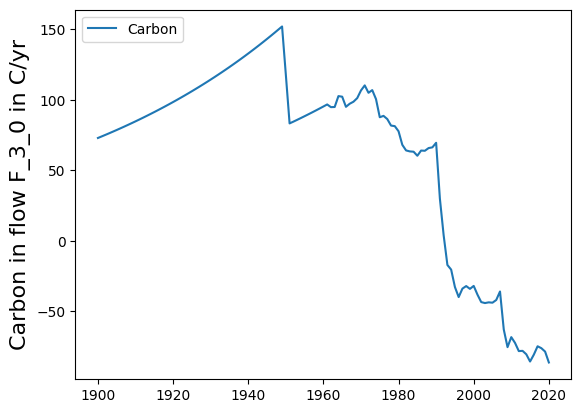

In [29]:
plt.set_loglevel("info")
fig, ax = plt.subplots()
ax.plot(mfa_system.IndexTable['Classification']['Time'].Items,
        mfa_system.FlowDict['F_1_4'].Values[:, 0])
ax.set_ylabel('Carbon in flow F_3_0 in C/yr', fontsize=16)
ax.legend(['Carbon'], loc='upper left')

#print(mfa_system.FlowDict['F_1_4'].Values)

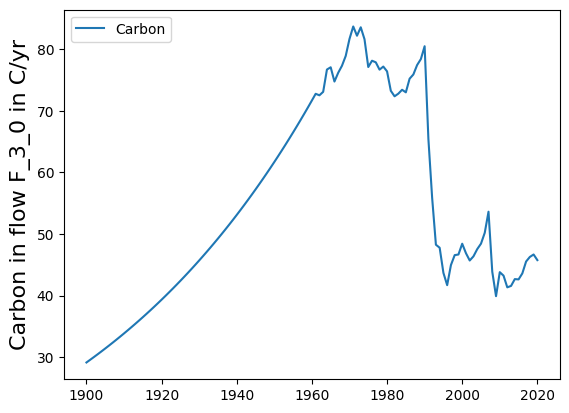

In [30]:
plt.set_loglevel("info")
fig, ax = plt.subplots()
ax.plot(mfa_system.IndexTable['Classification']['Time'].Items,
        mfa_system.FlowDict['F_1_3'].Values[:, 0])
ax.set_ylabel('Carbon in flow F_3_0 in C/yr', fontsize=16)
ax.legend(['Carbon'], loc='upper left')
# plt.ylim(0, 150)


#print(mfa_system.FlowDict['F_3_0'].Values)

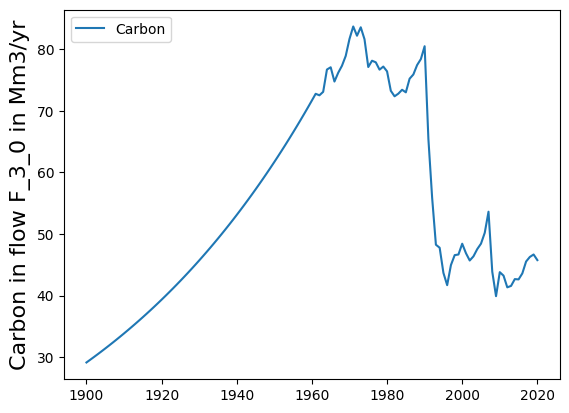

In [31]:
plt.set_loglevel("info")
fig, ax = plt.subplots()
ax.plot(mfa_system.IndexTable['Classification']['Time'].Items,
        mfa_system.FlowDict['F_2_0'].Values[:, 0])
ax.set_ylabel('Carbon in flow F_3_0 in Mm3/yr', fontsize=16)
ax.legend(['Carbon'], loc='upper left')
# plt.ylim(0, 150)

#print(mfa_system.FlowDict['F_2_0'].Values)

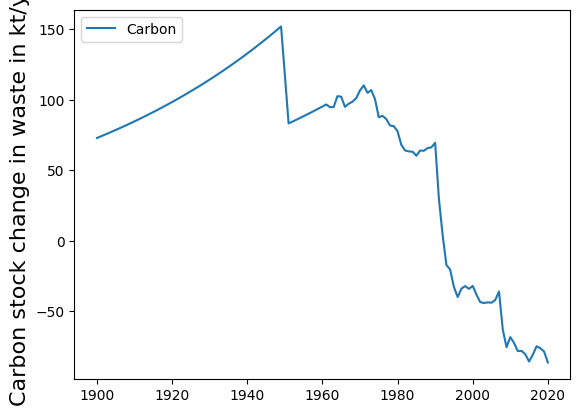

In [32]:
plt.set_loglevel("info")
fig, ax = plt.subplots()
ax.plot(mfa_system.IndexTable['Classification']['Time'].Items,
        mfa_system.StockDict['dS_Waste'].Values[:, 0])
ax.set_ylabel('Carbon stock change in waste in kt/yr', fontsize=16)
ax.legend(['Carbon'], loc='upper left')
# plt.ylim(0, 150)

#print(mfa_system.StockDict['dS_Waste'].Values)

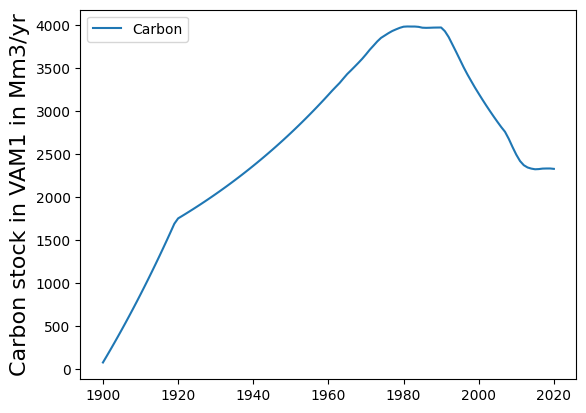

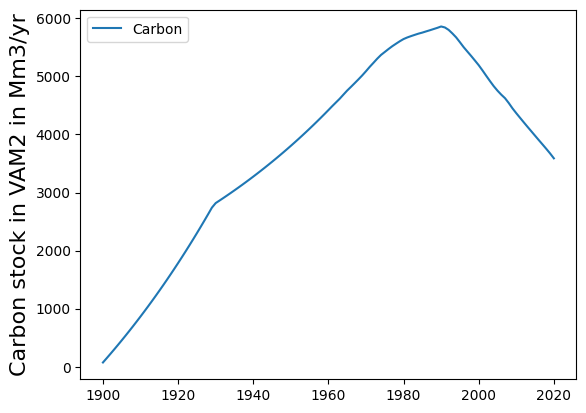

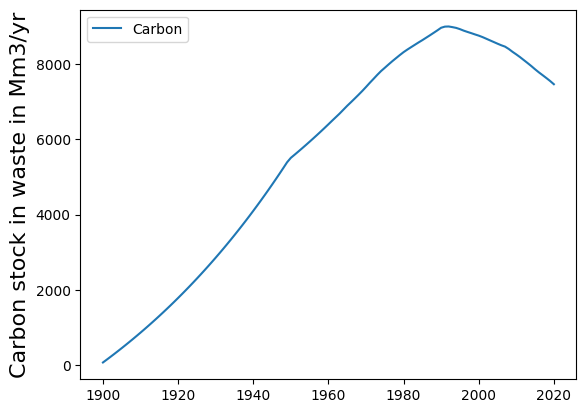

In [33]:
plt.set_loglevel("info")
fig, ax = plt.subplots()
ax.plot(mfa_system.IndexTable['Classification']['Time'].Items,
        mfa_system.StockDict['S_VAM1'].Values)
ax.set_ylabel('Carbon stock in VAM1 in Mm3/yr', fontsize=16)
ax.legend(['Carbon'], loc='upper left')

plt.set_loglevel("info")
fig, ax = plt.subplots()
ax.plot(mfa_system.IndexTable['Classification']['Time'].Items,
        mfa_system.StockDict['S_VAM2'].Values)
ax.set_ylabel('Carbon stock in VAM2 in Mm3/yr', fontsize=16)
ax.legend(['Carbon'], loc='upper left')

plt.set_loglevel("info")
fig, ax = plt.subplots()
ax.plot(mfa_system.IndexTable['Classification']['Time'].Items,
        mfa_system.StockDict['S_Waste'].Values)
ax.set_ylabel('Carbon stock in waste in Mm3/yr', fontsize=16)
ax.legend(['Carbon'], loc='upper left')


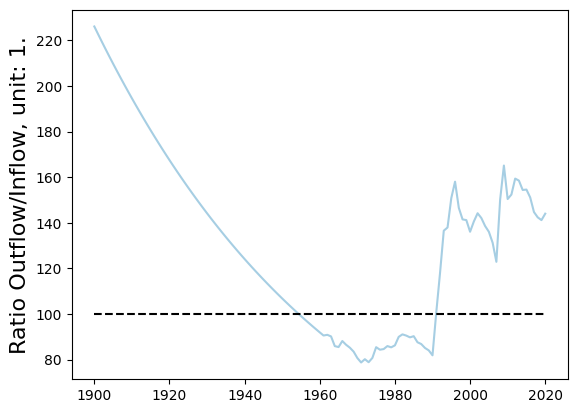

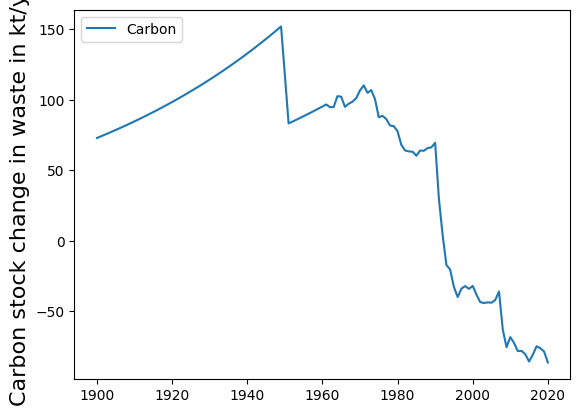

In [34]:
flowratio = mfa_system.FlowDict['F_2_0'].Values.sum(axis=0) \
            / mfa_system.FlowDict['F_1_2'].Values

# FlowRatio[np.isnan(FlowRatio)] = 0  # Set all ratios where reference flow F_0_1 was zero to zero, not nan.

MyColorCycle = pylab.cm.Paired(np.arange(0, 1, 0.1))  # select 10 colors from the 'Paired' color map.
fig, ax = plt.subplots()
ax.plot(mfa_system.IndexTable['Classification']['Time'].Items,
        flowratio, color=MyColorCycle[0])
ax.plot([starting_year, ending_year], [100, 100], color='k', linestyle='--')
ax.set_ylabel('Ratio Outflow/Inflow, unit: 1.', fontsize=16)
# ax.legend(MyRegions, loc='upper left', prop={'size': 8})


plt.set_loglevel("info")
fig, ax = plt.subplots()
ax.plot(mfa_system.IndexTable['Classification']['Time'].Items,
        mfa_system.StockDict['dS_Waste'].Values[:, 0])
ax.set_ylabel('Carbon stock change in waste in kt/yr', fontsize=16)
ax.legend(['Carbon'], loc='upper left')
# plt.ylim(0, 150)
